In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
import numpy as np
import matplotlib.pyplot as plt

from laenge.net import LaengeNet, LaengeNetLossFunc
from laenge.dataset import LaengeDataset
from laenge.act import ChenSundman, Softplus
from utils.plot import PlotHandler 
from sgte.handler import SGTEHandler

In [2]:
def epoch(net: LaengeNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), 5])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp, debug=True)
        
        # Get the loss
        g /= 1000
        h /= 1000
        entropy *= 1000
        heat_cap *= 1000
        
        #print(gibbs_energy[0], g[0])
        #print(entropy[0], s[0])
        #print(enthalpy[0], h[0])
        #print(heat_cap[0], c[0])
        #print('')
        
        loss, gl, sl, hl, cl = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), 
                                         h.float(), heat_cap.float(), c.float(), debug=False)
        
        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i, 0] = loss
        epoch_losses[i, 1] = gl
        epoch_losses[i, 2] = sl
        epoch_losses[i, 3] = hl
        epoch_losses[i, 4] = cl
    
    #print(gl, sl, hl, cl)
    #print(sl.mean(axis=0)/gl.mean(axis=0), hl.mean(axis=0)/gl.mean(axis=0), cl.mean(axis=0)/gl.mean(axis=0), '\n')
    #print(gibbs_energy[0], entropy[0], enthalpy[0], heat_cap[0])

    mean_epoch_loss = epoch_losses.mean(axis=0)
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [26]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 5000
    lr = 0.00075
    batch_size = 64
    #loss_weights = [1, 1300000, 0.01, 300000]
    #loss_weights = [1, 1300000, 0.01, 150000]
    loss_weights = [1/100, 7.5/100, 1.5/100, 2.5/100]

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = LaengeNetLossFunc(weights=loss_weights)

    losses = []
    
    best_loss = epoch(net, dataloader, loss_func, optimizer)[0]
    best_net = net

    for i in range(n_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss[0])
        
        #loss_func.weights = [1, loss[1]/loss[2], loss[1]/loss[3], loss[1]/loss[4]]
        
        if loss[0] < best_loss:
            best_net = net
        
    return losses, net

In [ ]:
net = LaengeNet(init_args=(0.1, 0.2), init_func=nn.init.uniform_, hidden_dim_sub_net_2=64)
theta_E_real = 1.054571817 * 10 ** -34 * 1.7 * 10 ** 13 / (1.380649 * 10 ** -23)

net.sub_net_1.act_1._initialize_parameters(theta_E_real, 0., 0., 0.)

element = 'Fe'
phase = ['BCC_A2']
start_temp, end_temp = 200, 2000

dataset = LaengeDataset(element, phase, scaling=False, step=2, start_temp=start_temp, end_temp=end_temp)

losses, best_net = train(net, dataset)

In [28]:
print('theta_E: ', best_net.sub_net_1.act_1.theta_E)
print('E0: ', best_net.sub_net_1.act_1.E0)
print('a: ', best_net.sub_net_1.act_1.a)
print('b: ', best_net.sub_net_1.act_1.b)

theta_E:  Parameter containing:
tensor(129.8500)
E0:  Parameter containing:
tensor(-269.1245, requires_grad=True)
a:  Parameter containing:
tensor(-0.1074, requires_grad=True)
b:  Parameter containing:
tensor(-0.0538, requires_grad=True)


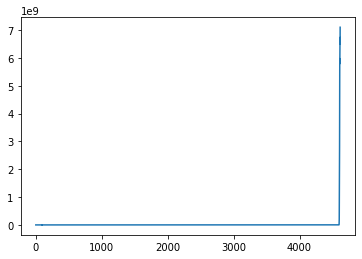

In [29]:
plt.plot(range(len(losses)), losses)

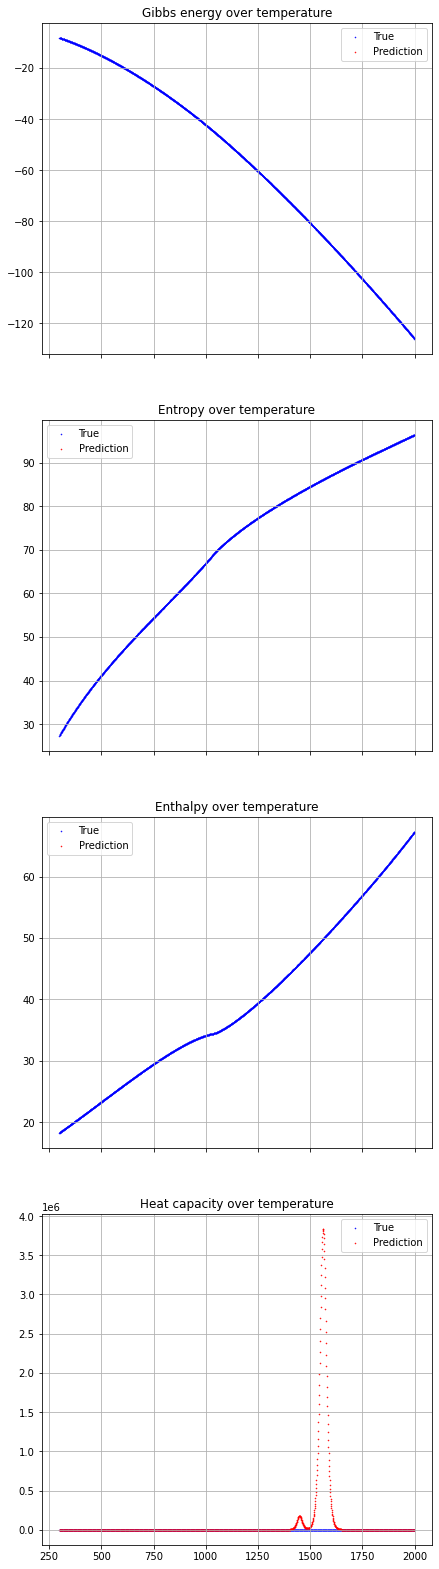

In [30]:
ph = PlotHandler('Laenge')

ph.properties_temp(best_net, element, phase, scaling=False, start_temp=start_temp, end_temp=end_temp)

In [ ]:
#torch.save(net, r'C:\Users\danie\Documents\Montanuni\Masterarbeit\5 Programmcodes\packages\laenge\laenge\models\model_04_03_22_1325')